# K-Nearest Neighbors

Principle : To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset—its “nearest neighbors.”
Simplest version : take THE closest neighbor (*k=1*)
Advanced version : take the K-nearest neighbors, using a voting system where the majority wins (*k=K*)
Let's start with *k=1* and see how it goes :

### Set up

First import all necessary packages in order not to worry about them when testing new parameters/algorithms:

In [12]:
%load_ext autoreload
%autoreload
from KNeighbors import display_plot, sober_results
from utils import thomas_parser

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First test

Before going further on with the first algorithm, let's retrieve the ground truth from a CSV file generated on the 13th of January 2020 at 2:25 PM. This ground truth gathers results from a thousand malwares collected on the 25th of June 2019.
The data are then splitted between the inputs and outputs as follow :

In [2]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

Let's now create the training and test sets. Since the dataset is quite small,the *80/20* rule is applied for the size of the sets. The *random_state* variable is a seed used to add randomness in the set. Since the purpose of the experiment is to compare results, deterministic values should be favored at first. The value is then set to 0.

In [3]:
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [4]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.79


This model is 79% accurate, which makes sense knowing that the 1000 samples dataset contains a majority of "not packed" malwares.
Let's try with a few other values :

In [5]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.80


In [6]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.83


In [7]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(data_train, target_train)
print("Test set accuracy: {:.2f}".format(neigh.score(data_test, target_test)))

Test set accuracy: 0.82


It's interesting to notice that increasing the number of neighbors doesn't always give better results, as the performance with *k=9* is better than *k=3* but worst than *k=6*. This can be more easily visualized with the graph here below.

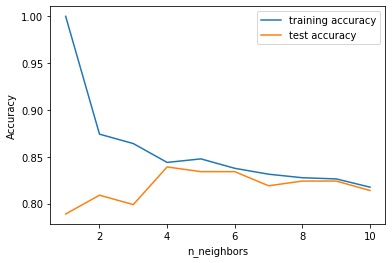

In [8]:
training_accuracy = [] 
test_accuracy = []
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

By looking at the figure, we can see that the best result obtained for the test set corresponds to a  value of *k=4*.
Before that, the model is probably overfitting.
Note that the overall accuracy is not really good. This can be explained because the K-NN algorithm does not perform well on datasets with a lot of features (and this dataset contains more than 100) and sparse datasets, which is also a caracteristic of the dataset used. Trying to preprocess the data might help to increase performance, although this algorithm is known to be really easy to understand and a good way to start experiment while being quite slow with many features.

### Further tests

In order to offer more diversity of tests, the code used before to generate the graph as been put into a Python file in order to be reused easily, namely the *display_plot* function. This method takes a csv (containing the ground truth), a test factor and a number of neighbors as parameters.
We also implemented another version that will only display the results without the plots for more convenience, called *sober_results*.

#### Parameters of the algorithm

In this section, we only change the values of the parameters related to the algorithm itself. Therefore, we stick to the same CSV file when running our tests, containing more samples than the one used in the first test (nearly 8000 lines).

##### Number of neighbors

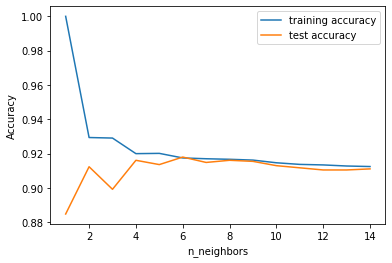

In [4]:
display_plot('../dumps/2020.02.10-12.14.csv',0.20,15)

Once again, we can see that the best results are provided when setting the number of neighbors to 6. Case where n=1 is an overfitting.

#### Minkowsi metric

This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used.

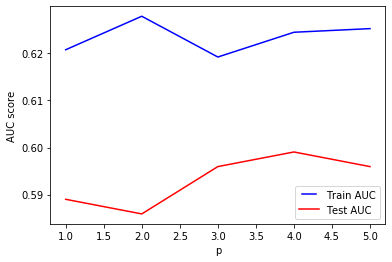

In [6]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(data_train, target_train)
   train_pred = model.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

It's quite interesting to notice that usually l=1 and l=2 are privileged values but in our case it is not. It seems like l=4 gives an overall best result.

##### Test factor

In [3]:
for i in range(10,100,10):
    i=i/100
    print("Test size of %s :"% i)
    sober_results('../dumps/2020.02.10-12.14.csv',i,6)

Test size of 0.1 :
Training set accuracy: 0.92
Test set accuracy: 0.93
Test size of 0.2 :
Training set accuracy: 0.92
Test set accuracy: 0.92
Test size of 0.3 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.4 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.5 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.6 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.7 :
Training set accuracy: 0.92
Test set accuracy: 0.91
Test size of 0.8 :
Training set accuracy: 0.91
Test set accuracy: 0.90
Test size of 0.9 :
Training set accuracy: 0.91
Test set accuracy: 0.90


### Best match

In [3]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [6]:
parameters = {'n_neighbors': np.arange(1,11), 'p':[1,2,3,4,5]}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

KeyboardInterrupt: 

In [ ]:
parameters = {'n_neighbors': np.arange(1,11), 'p':[1,2,3,4,5]}
clf = RandomizedSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

### Test with Thomas datasets

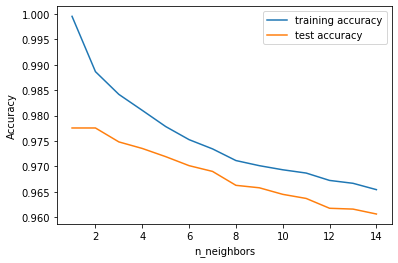

In [15]:
parsed_csv = thomas_parser("../dumps/2019-08.Merged")
gt = pd.read_csv(parsed_csv)
display_plot(parsed_csv,0.20,15)

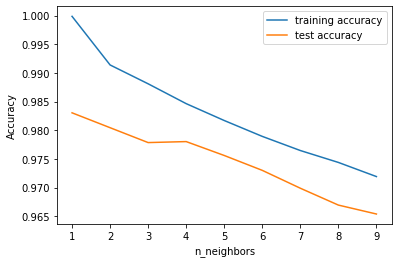

In [16]:
parsed_csv = thomas_parser("../dumps/2019-09.Merged")
gt = pd.read_csv(parsed_csv)
display_plot(parsed_csv,0.20,10)